# Construction of a "Create-Your-Own-ANN" Function

# (1): Introduction:

## (1.1) Introduction about ANNs:

In the following notebook, we will attempt to understand the idea of *Artificial Neural Networks (ANN) as being a Universal Function Approximator*.

While the words are fancy, the idea is simple: Artificial Neural Networks are fundamentally mathematical models that attempt to "learn" an unknown, "underlying" function. The learning process is guided by the tuning of several *parameters* in the network (that come in the form of weights and biases) based on the purely mathematical idea of optimizing a *loss function*. Let's briefly discuss the notation that we'll use to approach the problem:

Suppose some physical law relates quantities $x$ and $Y$ in a linear way: $y = f(x) = \alpha x$. Here $\alpha$ is a constant number that we call a "parameter." In our example, we may assume it to be "fundamental constant of Nature." Then, what we have is an "underlying function" that is $f(x) = \alpha x$. An experiment may measure $y$ several times with knowledge of $x$. We take it as a given that the experiment is, in some sense, by definition will not return for us a perfect value of $y$. In other words, while we might know $x$ to within  $\sigma_{x} = 5\%$, we might only be able to measure $y$ to within $\sigma_{y} = 10\%$. ($\sigma_{x}$ is to be read as "uncertainty in $x$.") So, the main challenge can now be worded as follows: *Supposing we don't know the underlying function of nature but can measure $x$ and $y$. Can, given enough (experimental) data, can an ANN by itself learn the underlying function even with the uncertainty in the data?*

## (1.2): Introduction about the Function:

We're not only concerned about the creation of a standard, feed-forward, densely-connected ANN, but we're also going to design a user-controlled workflow that sets up an entire TensorFlow model just with user input. Instead of hard-coding seventeen models in fifteen hours, we're going to code a function that essentially allows the user to define whatever TensorFlow model they want on the spot. If we can truly realize this idea, then we'll try to "generalize" the function to allow for more customization of loss functions and activation functions and so on. Right now, what we want is a proof of concept.

# (2): Import Relevant Libraries

In [23]:
%matplotlib inline

import numpy as np
import tensorflow as tensorflow
import matplotlib.pyplot as plt

We'll obviously need Numpy. We'll obviously need TensorFlow. Later, we'll do some plotting, which makes the import of Matplotlib necessary, too.

# (2): Define Unusual, Global Constants

In [24]:
INTEGER_ZERO = 0

PANDAS_AXIS_ROWS = 0 # Just a setting
PANDAS_AXIS_COLUMNS = 1 # Just a setting

I always forget what the stupid documentation requires certain keyword arguments to be. So, isntead of me forgetting every single time, I am just going to make stupid global (static) variables that remind me of it.

# (3): Wrapper Functions

I don't know what to say. We need to time (and describe) these things so that we know exactly what is happening and how long it took.

In [25]:
def function_output_desciption_wrapper(function_to_describe, verbose = False):
    """
    Description
    --------------
    A wrapper function that will explicitly describe what the output of a 
    function with name NAME actually was and its type.

    
    Parameters
    --------------
    function_to_describe : (func)

    verbose : (bool)

    
    Function Flow
    --------------
    (1): All we do is obtain the function name and say that it's currently running.
    (2): Next, we execute the function, and obtain its output.
    (3): We also obtain the datatype of the output.
    (4): We remark that the function has finished running.
    (5): Then, we just print the output of the function and its type.

    
    Notes
    --------------
    None
    """
    def wrapper(*args, **kwargs):
        
        if verbose:
            print(f"> Function \"{function_to_describe.__name__}\" is now running...")

        output_of_function = function_to_describe(*args, **kwargs)
        type_of_function_output = type(output_of_function)

        if verbose:
            print(f"> Function \"{function_to_describe.__name__}\" finished running. ")

        print(f"> The output of \"{function_to_describe.__name__}\" was:\n> {output_of_function} ({type_of_function_output})")
        
        return output_of_function
    
    return wrapper

def timer_wrapper(function_to_time, verbose = False):
    """
    This is a wrapper function that serves as a decorator
    for other functions that informs us how long (in seconds)
    it takes for those functions to run.


    Parameters
    --------------
    function_to_time : (func)
    
    verbose : (bool)


    ----- FUNCTION FLOW -----
    (1): Try to import the native module "Time."
    (2): Start the timer.
    (3): Run the function.
    (4): End the timer when the variable "function_result" has
        been obtained.
    (5): Compute the difference in end time from start time.
    (6): Log the output, which states how long the function took 
        to run.
    -------------------------

    
    Notes
    --------------
    None
    """

    # (1): Try to import the native module "Time":
    try:
        import time
    except Exception as E:
        print(f"> Error running timer wrapper:\n> {E}")
        return 0

    def wrapper(*args, **kwargs):

        # (2): Start the timer.
        start_time = time.time()
        if verbose:
            print(f"> Function \"{function_to_time.__name__}\" began running {start_time}.")

        # (3): Run the function.
        function_result = function_to_time(*args, **kwargs)
    
        # (4): End the timer.
        end_time = time.time()
        if verbose:
            print(f"> Function \"{function_to_time.__name__}\" began running {start_time}.")

        # (5): Compute the difference.
        elapsed_time = end_time - start_time

        # (6): Log the output.
        print(f"> Function \"{function_to_time.__name__}\" took {elapsed_time:.6f} seconds to run.")
        
        return function_result

    return wrapper

# (4): Designing the "Experimental Data"

Now, we are going to construct the major functions that we're going to use. Recall (the trivial expression) that we want to assume some "fundamental law of nature" has the form $y(x) = A x^{2} + B x + C$. We are going to attempt to guess this fundamental law of nature, which clearly involves the extraction of the three parameters $A, B,$ and $C$. In this unusual sense, nature has "encoded" three fundamental constants that we need to attempt to derive using neural network techniques.

The idea is the following:

(i): First, we'll make a standard quadratic function that takes a given $x$ and those three parameters. This function is obviously essential when we assess the veracity of the model.

(ii): In order to simulate experimental "uncertainty," we'll code a function that allows sampling from a Normal Distribution. Remember that a Normal Distribution ($\mathcal{N} (\mu, \sigma)$) is characterized by the mean ($\mu$) and the standard deviation ($\sigma$), and that sampling from this function means that you'll have a probability of $P \approx 68.2 \%$ of obtaining values of $\mu \pm \sigma$ and $P \approx 95\%$ of obtaining values of $\mu \pm 2 \sigma$.

(iii): We'll also need to then write a function that also samples our underlying function -- the quadratic. Our experiment is designed to measure $y$ to within some uncertainty. That uncertainty comes from the sampling as well. Instead of plugging-and-chugging into the quadratic equation for some given value of $x$ and calling it a day, we first plug-and-chug to obtain the accurate value of $y$, and then we'll use that value of $y$ as the mean in another Normal Distribution characterized by $\mathcal{N}(\mu = y, \sigma_{y} = ?)$.

## (4.1): Quadratic Function:

In [26]:
@timer_wrapper
def quadratic_function(x, coefficient_a, coefficient_b, coefficient_c):
    """
    Description
    --------------
    Returns the output of a quadratic function given an input and the 
    standard three parameters characterizing a quadratic function.

    
    Parameters
    --------------
    x : (num)

    coefficient_a : (num)

    coefficient_b : (num)

    coefficient_c : (num)


    Function Flow
    --------------

    
    Notes
    --------------
    (1): The quadratic function has three "parameters." These are roughly
        called "A", "B", and "C." Only after specifying those three parameters
        will the function actually return an output given an input. In other
        words, besides supplying an independent variable, you need those
        three other pieces of information -- the parameters -- in order to
        get a number as an ouput.
    """
    try:
        corresponding_y_value = coefficient_a * x**2 + coefficient_b * x + coefficient_c
        return corresponding_y_value
    except Exception as E:
        return INTEGER_ZERO

## (4.2): Sampling a Normal Distribution:

In [27]:
@timer_wrapper
def sample_normal_distribution(mean_value, standard_deviation):
    """
    Description
    --------------
    Uses Numpy's function random.normal() to sample a normal distribution
    with a mean of "loc" and a standard deviation of "scale," the two WORST
    KWARGS I'VE EVER SEEN IN PYTHON.

    
    Parameters
    --------------
    mean : (float)

    standard_deviation : (float)


    Function Flow
    --------------

    
    Notes
    --------------
    (1): The quadratic function has three "parameters." These are roughly
        called "A", "B", and "C." Only after specifying those three parameters
        will the function actually return an output given an input. In other
        words, besides supplying an independent variable, you need those
        three other pieces of information -- the parameters -- in order to
        get a number as an ouput.
    """
    try:
        randomly_sampled_variable = np.random.normal(
            loc = mean_value,
            scale = standard_deviation
        )
        return randomly_sampled_variable
    
    except Exception as E:
        print(f"> Error in sampling normal distribution:\n> {E}!")
        return None

## (4.3): Sample Underlying Function:

In [28]:
@timer_wrapper
def sample_underlying_function(x_value):
    """
    Description
    --------------
    This function provides a method to generate 
    so-called "experimental data" that comes from an
    underlying function.

    Parameters
    --------------

    Function Flow
    --------------

    Notes
    --------------
    None
    """
    _PARAMETER_A = 2
    _PARAMETER_B = -3
    _PARAMETER_C = 1

    _RANDOM_NOISE_MEAN = 0
    _RANDOM_NOISE_STANDARD_DEVIATION = 0.29578
    
    try:
        quadratic_function_ouput = quadratic_function(x_value, _PARAMETER_A, _PARAMETER_B, _PARAMETER_C)
        random_noise_contribution = sample_normal_distribution(_RANDOM_NOISE_MEAN, _RANDOM_NOISE_STANDARD_DEVIATION)
        return quadratic_function_ouput + random_noise_contribution
    
    except Exception as E:
        print(f"> Error in the quadratic formula: {E}")
        return 0

Now, we test the above code to see if it works:

In [29]:
sample_underlying_function(5)

> Function "quadratic_function" took 0.000000 seconds to run.
> Function "sample_normal_distribution" took 0.000000 seconds to run.
> Function "sample_underlying_function" took 0.000000 seconds to run.


35.876490793267116

## (4.4): Generating Pseudodata:

Remember that ANNs need to train on data. Since we have no actual data, we need to generate our own; This reason is partially why we call it *pseudo*data. We generate pseudodata by running a huge loop that implements the sampling functions. What we want to obtain is a list of $x-$values and $y-$values such that they row-by-row correspond with one another. In other words, the $i-$th element in the $x-$value list ought to physically mean that our fancy experiment recorded that $x-$value and then measured the corresponding $i-$th element in the $y-$value list. More explicitly and less full of jargon, we're just saying that if we have the following two arrays,

```python
x_values = [1, 2, 3, ...]
y_values = [5.4, 6.5, 7.5, ...]
```

then we are to interpret that our experiment measured $x$ as $2$ and then measured $y$ as $6.5$. These lists constitute our pseudodata.

In [30]:
def generate_pseudodata(n_rounds):
    """
    Description
    --------------
    We generate, for N-rounds, a collection of outputs based on inputs.
    In essence, this is just plugging-and-chugging, for a given list of 
    x-values, what some f(x) is. In this case, we are using the quadratic
    function as the "underlying function" to generate our output.

    Parameters
    --------------

    Function Flow
    --------------
    
    Notes
    --------------
    (1): 


    """
    _are_sampling_normal_distribution = False
    _X_MEAN_VALUE = 0
    _X_STANDARD_DEVIATION = np.random.choice([1.2, 1.5], 1)[0]

    pseudodata_x_values = []
    pseudodata_y_values = []

    for iteration in range(n_rounds):

        if _are_sampling_normal_distribution:
            randomly_sampled_x = sample_normal_distribution(_X_MEAN_VALUE, _X_STANDARD_DEVIATION)
            
        else:
            randomly_sampled_x = 0.1 * np.random.randint(-100, 100)
        pseudodata_x_values.append(randomly_sampled_x)
        pseudodata_y_values.append(sample_underlying_function(randomly_sampled_x))

    return pseudodata_x_values, pseudodata_y_values 

Now, we test to see if the function works:

In [31]:
X, Y = generate_pseudodata(100)

> Function "quadratic_function" took 0.000000 seconds to run.
> Function "sample_normal_distribution" took 0.000000 seconds to run.
> Function "sample_underlying_function" took 0.000000 seconds to run.
> Function "quadratic_function" took 0.000000 seconds to run.
> Function "sample_normal_distribution" took 0.000000 seconds to run.
> Function "sample_underlying_function" took 0.000000 seconds to run.
> Function "quadratic_function" took 0.000000 seconds to run.
> Function "sample_normal_distribution" took 0.000000 seconds to run.
> Function "sample_underlying_function" took 0.000000 seconds to run.
> Function "quadratic_function" took 0.000000 seconds to run.
> Function "sample_normal_distribution" took 0.000000 seconds to run.
> Function "sample_underlying_function" took 0.000000 seconds to run.
> Function "quadratic_function" took 0.000000 seconds to run.
> Function "sample_normal_distribution" took 0.000000 seconds to run.
> Function "sample_underlying_function" took 0.000000 second

## (4.5): Visualizing Data:

Let's quickly code up a plotting function that just gives us a visual idea of how our pseudodata are distributed.

In [32]:
def generate_plot_of_experimental_data(x_data, y_data):
    """
    Description
    --------------
    Produce a plot of the experimental data: y vs. x. We are absolutely
    not doing anything fancy here in the slightest regarding the aesthetics.
    We'll do that later.

    
    Parameters
    --------------
    x_data : Array-like:
        The data along the x-axis.

    y_data : Array-like
        The data along the y-axis.

        
    Notes
    --------------
    This function replies on Matplotlib's Pyplot feature.

    """
    return plt.scatter(x_data, y_data)

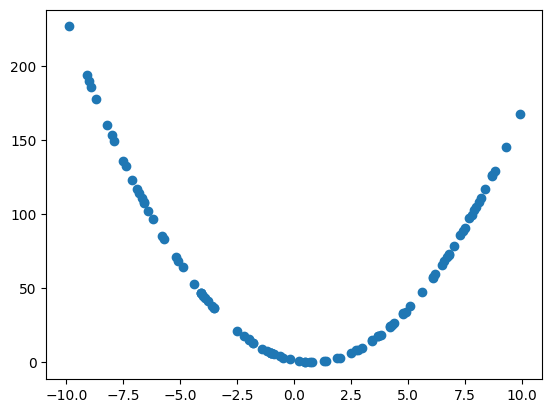

In [33]:
generate_plot_of_experimental_data(X, Y)

# (5): Coding the Build-Your-Own-ANN

Now, we turn our attention to the construction of an ANN that allows us to extract the underlying form of this function. The framework we are going to code our ANN in is Keras (TensorFlow). So, we need to first understand what the hell TensorFlow requires in order to actually set up and run a neural network. Then, following those requirements, we'll construct the functions that define the main things that constitute a neural network. Let's actually recap that right now.

First of all, we're going to code up a bunch of boring prompt statements that should not vary in the code execution. This might not be the best practice, but it's fun.

In [34]:
INPUT_PROMPT_NUMBER_1_NUMBER_OF_ANN_LAYERS = "> How many layers do you want in your ANN architecture?"
INPUT_PROMPT_NUMBER_2_NODES_PER_LAYER = "> Choose how many nodes you want for layer {}."
INPUT_PROMPT_NUMBER_3_ACTIVATION_FUNCTION = "> Choose an activation function for layer {}."
INPUT_PROMPT_NUMBER_4_ACTIVATION_FUNCTION = "> Please select the network's loss function."
INPUT_PROMPT_NUMBER_5_INPUT_SHAPE = "> Please specify the number of inputs of your network."

ERROR_PROMPT_NUMBER_1_LAYER_NUMBER_NOT_INT = "> Layer number must be a positive, nonzero integer. Continuing..."
ERROR_PROMPT_NUMBER_2_NODES_PER_LAYER_NOT_INTEGER = "> Number of nodes per layer must be an integer type. Continuing..."
ERROR_PROMPT_NUMBER_3_ACTIVATION_FUNCTION_NOT_STRING = "> Activation functions are of string datatype. Continuing..."
ERROR_PROMPT_NUMBER_3_ACTIVATION_FUNCTION_NOT_IN_LIST = "> User input of `{}` is not included in known list of activation functions."
ERROR_PROMPT_NUMBER_4_LOSS_FUNCTION_NOT_STRING = "> The provided loss function was not a string type. Provide one that is. Continuing..."
ERROR_PROMPT_NUMBER_4_LOSS_FUNCTION_NOT_IN_LIST = "> User input of `{}` is not included in known list of loss functions."
ERROR_PROMPT_NUMBER_5_INPUT_SHAPE_INTEGER = "> The user input of {} wasn't an integer."
ERROR_PROMPT_NUMBER_5_INPUT_SHAPE_NEGATIVE = "> Obviously, the size of the input vector cannot be zero or negative."

## (5.1): Obtain the Number of Hidden Layers in the Network:

In [35]:
def obtain_number_of_ANN_hidden_layers(verbose = False):
    """
    Description
    --------------
    Obtain the number of hidden layers for the ANN from the user.

    
    Parameters
    --------------
    verbose (boolean):
        Do you want to see all output of this function evaluation?
        
    Notes
    --------------
    (1) We just need to obtain a nonzero, positive integer that
    represents the number of layers in the ANN.

    (2) https://stackoverflow.com/a/23294659 -> For a healthy way
    to construct a while loop like this.
    """
    while True:

        try:
            
            number_of_ANN_layers = int(input(INPUT_PROMPT_NUMBER_1_NUMBER_OF_ANN_LAYERS))
            
            if verbose:
                print(f"> Received input: {number_of_ANN_layers} ({type(number_of_ANN_layers)}).")

        except ValueError:

            print(ERROR_PROMPT_NUMBER_1_LAYER_NUMBER_NOT_INT)
            continue

        if number_of_ANN_layers <= 0:

            print(ERROR_PROMPT_NUMBER_1_LAYER_NUMBER_NOT_INT)
            continue

        else:
            
            print(f"> Received input: {number_of_ANN_layers} ({type(number_of_ANN_layers)}). Exiting...")
            break

    if verbose:
        print(f"> User defined {number_of_ANN_layers} Layers in the network.")

    return number_of_ANN_layers

Let's now test this function:

In [36]:
obtain_number_of_ANN_hidden_layers()

> Layer number must be a positive, nonzero integer. Continuing...
> Received input: 3 (<class 'int'>). Exiting...


3

## (5.2): For Each Layer, Obtain the Number of Nodes per Layer:

In [37]:
def obtain_nodes_per_layer(number_of_ANN_layers, verbose = False):
    """
    Description
    --------------
    Obtain the number of nodes per layer in the ANN.

    
    Parameters
    --------------
    number_of_ANN_layers (int):
        the number of layers in the ANN

    verbose (boolean):
        prints the intermediate computations of the function
     
    Notes
    --------------
    (1) For all each layer, we need to populate it with a number of neurons.
        So, this function is about obtaining a list of intergers that correspond
        to the number of neurons per layer.

    (2) The output is a list of integers.
    """
    list_of_number_of_nodes_per_layer = []

    for layer_index in range(number_of_ANN_layers):

        while True:

            try:

                number_of_nodes_per_given_layer = int(input(INPUT_PROMPT_NUMBER_2_NODES_PER_LAYER.format(layer_index + 1)))

                if verbose:
                    print(f"> Received input: {number_of_nodes_per_given_layer} ({type(number_of_nodes_per_given_layer)}).")

            except ValueError:

                print(ERROR_PROMPT_NUMBER_2_NODES_PER_LAYER_NOT_INTEGER)
                continue

            print(f"> Received input: {number_of_nodes_per_given_layer} ({type(number_of_nodes_per_given_layer)}). Exiting...")
            list_of_number_of_nodes_per_layer.append(number_of_nodes_per_given_layer)
            break
        
        print(f"> User defined Layer #{layer_index + 1} to have {number_of_nodes_per_given_layer} nodes.")

    return list_of_number_of_nodes_per_layer

Let's test this function:

In [38]:
obtain_nodes_per_layer(5)

> Received input: 5 (<class 'int'>). Exiting...
> User defined Layer #1 to have 5 nodes.
> Received input: 5 (<class 'int'>). Exiting...
> User defined Layer #2 to have 5 nodes.
> Received input: 1 (<class 'int'>). Exiting...
> User defined Layer #3 to have 1 nodes.
> Received input: 1 (<class 'int'>). Exiting...
> User defined Layer #4 to have 1 nodes.
> Received input: 1 (<class 'int'>). Exiting...
> User defined Layer #5 to have 1 nodes.


[5, 5, 1, 1, 1]

## (5.3): For Each Layer, Obtain the Activation Function that will Apply to Each Node:

In [39]:
def check_if_activation_function_included(user_entered_activation_function = None):
    """
    Description
    --------------
    Sanitize/verify that the user-typed string corresponds to a given and known
    activation function. Checks against the TensorFlow nomenclature.

    
    Parameters
    --------------
    user_entered_activation_function (string):
        the name of the desired activation function for the layer of nodes
        
    
    Notes
    --------------
    (1): At this stage, we are actually validating the list of valid activation function
        names. There's no real reason to do this, but it keeps us accountable.

    """

    _ACTIVATION_FUNCTIONS_STRING_ELU = "elu"
    _ACTIVATION_FUNCTIONS_STRING_EXPONENTIAL = "exponential"
    _ACTIVATION_FUNCTIONS_STRING_GELU = "gelu"
    _ACTIVATION_FUNCTIONS_STRING_HARD_SIGMOID = "hard_sigmoid"
    _ACTIVATION_FUNCTIONS_STRING_LINEAR = "linear"
    _ACTIVATION_FUNCTIONS_STRING_MISH = "mish"
    _ACTIVATION_FUNCTIONS_STRING_RELU = "relu"
    _ACTIVATION_FUNCTIONS_STRING_SELU = "selu"
    _ACTIVATION_FUNCTIONS_STRING_SIGMOID = "sigmoid"
    _ACTIVATION_FUNCTIONS_STRING_SOFTMAX = "softmax"
    _ACTIVATION_FUNCTIONS_STRING_SOFTPLUS = "softplus"
    _ACTIVATION_FUNCTIONS_STRING_SOFTSIGN = "softsign"
    _ACTIVATION_FUNCTIONS_STRING_SWISH= "swish"
    _ACTIVATION_FUNCTIONS_STRING_TANH = "tanh"

    _ARRAY_OF_ACCEPTABLE_ACTIVATION_FUNCTIONS = [
        _ACTIVATION_FUNCTIONS_STRING_ELU,
        _ACTIVATION_FUNCTIONS_STRING_EXPONENTIAL,
        _ACTIVATION_FUNCTIONS_STRING_GELU,
        _ACTIVATION_FUNCTIONS_STRING_HARD_SIGMOID,
        _ACTIVATION_FUNCTIONS_STRING_LINEAR,
        _ACTIVATION_FUNCTIONS_STRING_MISH,
        _ACTIVATION_FUNCTIONS_STRING_RELU,
        _ACTIVATION_FUNCTIONS_STRING_SELU,
        _ACTIVATION_FUNCTIONS_STRING_SIGMOID,
        _ACTIVATION_FUNCTIONS_STRING_SOFTMAX,
        _ACTIVATION_FUNCTIONS_STRING_SOFTPLUS,
        _ACTIVATION_FUNCTIONS_STRING_SOFTSIGN,
        _ACTIVATION_FUNCTIONS_STRING_SWISH,
        _ACTIVATION_FUNCTIONS_STRING_TANH,
    ]
    if user_entered_activation_function == None:
        return False
    else:
        if user_entered_activation_function in _ARRAY_OF_ACCEPTABLE_ACTIVATION_FUNCTIONS:
            return True
        else:
            return False


Test the function:

In [40]:
check_if_activation_function_included("loss")

False

In [41]:
check_if_activation_function_included("linear")

True

## (5.4): Actually Obtain the Activation Functions per Layer:

Now, all we need to do is construct a list of strings that will correspond to the activation functions that will apply to the nodes in a given layer.

In [42]:
def construct_array_of_layer_activation_functions(number_of_ANN_layers, verbose = False):
    """
    Description
    --------------
    Obtain the activation functions for each neuron in a given layer 
    from the user. There are only a few acceptable options for the 
    types of activation functions.


    Parameters
    --------------
    number_of_ANN_layers (int): 
        The number of layers, not including the input data, in the network.
    
        
    Notes
    --------------
    (1) For all neurons in a given layer, we will apply the same activation function.
    """
    list_of_activation_functions_for_each_layer = []

    for layer_index in range(number_of_ANN_layers):

        while True:

            try:

                user_proposed_activation_function = str(input(INPUT_PROMPT_NUMBER_3_ACTIVATION_FUNCTION.format(layer_index + 1)))
                if verbose:
                    print(f"> Received input: {user_proposed_activation_function} ({type(user_proposed_activation_function)}).")

            except ValueError:

                print(ERROR_PROMPT_NUMBER_3_ACTIVATION_FUNCTION_NOT_STRING)
                continue

            if not check_if_activation_function_included(user_proposed_activation_function):

                print(ERROR_PROMPT_NUMBER_3_ACTIVATION_FUNCTION_NOT_IN_LIST.format(user_proposed_activation_function))
                continue

            else:

                print(f"> Received input: {user_proposed_activation_function} ({type(user_proposed_activation_function)}). Exiting...")
                list_of_activation_functions_for_each_layer.append(user_proposed_activation_function)
                break
        
        print(f"> User defined layer number {layer_index + 1} to use {user_proposed_activation_function} activation.")

    return list_of_activation_functions_for_each_layer

Let's now test this function:

In [43]:
construct_array_of_layer_activation_functions(3)

> Received input: relu (<class 'str'>). Exiting...
> User defined layer number 1 to use relu activation.
> Received input: relu (<class 'str'>). Exiting...
> User defined layer number 2 to use relu activation.
> Received input: relu (<class 'str'>). Exiting...
> User defined layer number 3 to use relu activation.


['relu', 'relu', 'relu']

## (5.5) Obtain the Model's Loss Function

All we need to do is provide an interface for the user to enter the name of a loss function that the network will use to perform backpropagation.

In [44]:
def check_if_loss_function_included(user_entered_loss_function = None):
    """
    Description
    --------------
    Sanitize/verify that the user-typed string corresponds to a given and known
    activation function. Checks against the TensorFlow nomenclature.

    
    Parameters
    --------------
    user_entered_activation_function (string): 
        the name of the desired loss functions
        
    
    Notes
    --------------
    (1): This is just an intermediate validation. We want to make sure we
        are referring to things that exist. That's why we put this 
        intermediate validation here.

    """
    _ARRAY_OF_ACCEPTABLE_LOSS_FUNCTIONS = [
        "binary crossentropy",
        "binary_focal crossentropy",
        "categorical crossentropy",
        "categorical focal crossentropy",
        "categorical hinge",
        "cosine similarity",
        "hinge",
        "huber",
        "kl divergence",
        "log cosh",
        "loss",
        "mean absolute error",
        "mean absolute percentage error",
        "mean squared error",
        "mean squared logarithmic error",
        "poisson",
        "reduction",
        "sparce categorical crossentropy",
        "squared hinge"
    ]

    if user_entered_loss_function == None:
        return False
    else:
        if user_entered_loss_function in _ARRAY_OF_ACCEPTABLE_LOSS_FUNCTIONS:
            return True
        else:
            return False
        
def choose_network_loss_function(verbose = False):
    """
    Description
    --------------
    We need a loss function in comparing the model's terrible output with
    actual data. All this function involves is choosing the loss function.


    Parameters
    --------------
        verbose (boolean):
            prints out the intermediate steps in a calculation
    
        
    Notes
    --------------
    """
    while True:

        try:

            user_proposed_loss_function = str(input(INPUT_PROMPT_NUMBER_4_ACTIVATION_FUNCTION))
            if verbose:
                print(f"> Received user input of {user_proposed_loss_function} ({type(user_proposed_loss_function)}).")

        except ValueError:

            print(ERROR_PROMPT_NUMBER_4_LOSS_FUNCTION_NOT_STRING)
            continue

        if not check_if_loss_function_included(user_proposed_loss_function):

            print(ERROR_PROMPT_NUMBER_4_LOSS_FUNCTION_NOT_IN_LIST.format(user_proposed_loss_function))
            continue

        else:

            print(f"> Received user input of {user_proposed_loss_function} ({type(user_proposed_loss_function)}). Exiting...")
            break

    return user_proposed_loss_function

Let's test these functions.

In [45]:
choose_network_loss_function()

> User input of `relu` is not included in known list of loss functions.
> User input of `relu` is not included in known list of loss functions.
> Received user input of mean squared error (<class 'str'>). Exiting...


'mean squared error'

I used ChatGPT with the following query to construct the next part of the code:

> Write me a quick function in Python that accepts a user input. The user input should be a string, and I'd like it to be the name of a standard loss function. (You don't have to code any validation for this, but this is the general direction that we're going.) Once you have the string for the user's loss function, you need to then use that string to reference some sort of dictionary or other conveinent Python data type and return the corresponding Keras loss function instance. In other words, if my input is `"mean squared"`, then you need to return to me the actual instance of `tf.keras.losses.MeanSquaredError()`.

It sent me the following response:

> Certainly! You can create a function that takes a user input string, maps it to the corresponding Keras loss function instance using a dictionary, and returns that instance. Here's a simple example:
```python
import tensorflow as tf

def get_loss_function(user_input):
    # Define a dictionary mapping user inputs to Keras loss function instances
    loss_function_mapping = {
        "mean squared": tf.keras.losses.MeanSquaredError(),
        "mean absolute": tf.keras.losses.MeanAbsoluteError(),
        "categorical crossentropy": tf.keras.losses.CategoricalCrossentropy(),
        # Add more loss functions as needed
    }

    # Convert user input to lowercase for case-insensitivity
    user_input_lower = user_input.lower()

    # Return the corresponding Keras loss function instance
    return loss_function_mapping.get(user_input_lower, None)

# Example usage
user_loss_input = input("Enter a loss function name: ")
loss_function_instance = get_loss_function(user_loss_input)

if loss_function_instance:
    print(f"Selected Loss Function Instance: {loss_function_instance}")
else:
    print("Invalid loss function name. Please enter a valid loss function.")
```

> In this example, the get_loss_function function takes the user input, converts it to lowercase for case-insensitivity, and looks up the corresponding loss function instance in the loss_function_mapping dictionary. If the user input matches a known loss function, it returns the instance; otherwise, it returns None.

> You can expand the loss_function_mapping dictionary with additional loss functions as needed for your use case.

I just wanted to confirm that a legitimate way of doing the "translation" from a user input to some other thing that comes from a library can be implemented with a dictionary. I still don't know if this is common practice, but it does the job right now. So, I'm going to code up a dictionary to contains this correspondence.

In [46]:
_LOSSES_STRING_BINARY_CROSSENTROPY = "binary crossentropy"
_LOSSES_STRING_BINARY_FOCAL_CROSSENTROPY = "binary focal crossentropy"
_LOSSES_STRING_CATEGORICAL_CROSSENTROPY = "categorical crossentropy"
_LOSSES_STRING_CATEGORICAL_FOCAL_CROSSENTROPY = "categorical focal crossentropy"
_LOSSES_STRING_CATEGORICAL_HINGE = "cateogrical hinge"
_LOSSES_STRING_COSINE_SIMILARITY = "cosine similarity"
_LOSSES_STRING_HINGE = "hinge"
_LOSSES_STRING_HUBER = "huber"
_LOSSES_STRING_KL_DIVERGENCE = "kl divergence"
_LOSSES_STRING_LOG_COSH = "log cosh"
_LOSSES_STRING_LOSS = "loss"
_LOSSES_STRING_MEAN_ABSOLUTE_ERROR = "mean absolute error"
_LOSSES_STRING_MEAN_ABSOLULTE_PERCENTAGE_ERROR = "mean absolute percentage error"
_LOSSES_STRING_MEAN_SQUARED_ERROR = "mean squared error"
_LOSSES_STRING_MEAN_SQUARED_LOGARITHMIC_ERROR = "mean squared logarithmic error"
_LOSSES_STRING_POISSON = "poisson"
_LOSSES_STRING_REDUCTION = "reduction"
_LOSSES_STRING_SPARCE_CATEGORICAL_CROSSENTROPY = "sparce categorical crossentropy"
_LOSSES_STRING_SQUARED_HINGE = "squared hinge"

_DICTIONARY_MAP_USER_INPUT_TO_KERAS_LOSS = {
    _LOSSES_STRING_BINARY_CROSSENTROPY: tensorflow.keras.losses.BinaryCrossentropy(),
    _LOSSES_STRING_BINARY_FOCAL_CROSSENTROPY: tensorflow.keras.losses.BinaryFocalCrossentropy(),
    _LOSSES_STRING_CATEGORICAL_CROSSENTROPY: tensorflow.keras.losses.CategoricalCrossentropy(),
    _LOSSES_STRING_CATEGORICAL_FOCAL_CROSSENTROPY: tensorflow.keras.losses.CategoricalFocalCrossentropy(),
    _LOSSES_STRING_CATEGORICAL_HINGE: tensorflow.keras.losses.CategoricalHinge(),
    _LOSSES_STRING_COSINE_SIMILARITY: tensorflow.keras.losses.CosineSimilarity(),
    _LOSSES_STRING_HINGE: tensorflow.keras.losses.Hinge(),
    _LOSSES_STRING_HUBER: tensorflow.keras.losses.Huber(),
    _LOSSES_STRING_KL_DIVERGENCE: tensorflow.keras.losses.KLDivergence(),
    _LOSSES_STRING_LOG_COSH: tensorflow.keras.losses.LogCosh(),
    _LOSSES_STRING_LOSS: tensorflow.keras.losses.Loss(),
    _LOSSES_STRING_MEAN_ABSOLUTE_ERROR: tensorflow.keras.losses.MeanAbsoluteError(),
    _LOSSES_STRING_MEAN_ABSOLULTE_PERCENTAGE_ERROR: tensorflow.keras.losses.MeanAbsolutePercentageError(),
    _LOSSES_STRING_MEAN_SQUARED_ERROR: tensorflow.keras.losses.MeanSquaredError(),
    _LOSSES_STRING_MEAN_SQUARED_LOGARITHMIC_ERROR: tensorflow.keras.losses.MeanSquaredLogarithmicError(),
    _LOSSES_STRING_POISSON: tensorflow.keras.losses.Poisson(),
    _LOSSES_STRING_REDUCTION: tensorflow.keras.losses.Reduction(),
    _LOSSES_STRING_SPARCE_CATEGORICAL_CROSSENTROPY: tensorflow.keras.losses.SparseCategoricalCrossentropy(),
    _LOSSES_STRING_SQUARED_HINGE: tensorflow.keras.losses.SquaredHinge(),
}

def translate_user_input_loss_function_to_keras_loss_function(string_user_input_loss_function):
    """
    Description
    --------------
    All this function does is it takes a string of user input that is supposed to
    represent the name of some popular loss function (those included in TensorFlow)
    and attempt to match it with the existing classes available. If the class
    exists, we return that TF instance. If the class does not, then we tell the user
    to get good.

    Parameters
    --------------
    string_user_input_loss_function (string)
        the name of the desired loss function as a string
    
        
    Notes
    --------------
    (1): We reference a huge dictionary.
    """
    try:
        return _DICTIONARY_MAP_USER_INPUT_TO_KERAS_LOSS.get(string_user_input_loss_function, None)
    
    except Exception as E:
        print(f"> Error in translating input: {string_user_input_loss_function} to Keras Loss class instance:\n> {E}")
        return None

Does this work?

In [47]:
translate_user_input_loss_function_to_keras_loss_function("loss")

In [48]:
translate_user_input_loss_function_to_keras_loss_function("mean squared error")

That seems to do the trick.

## (5.6): Obtaining/Creating the Model's Input Layer

Next, we need to create the `Input()` layer for our model. This isn't too difficult to do at all, but I wanted to turn this into a specific function anyway. The idea is that I am looking for the "input dimension" of the input layer. If you want to feed the network 10 different numbers, then the input dimension is 10. There are more advanced cases which I don't understand, like feeding 5 $N \times N$ matrices as input to the network, but you should always be able to vectorize any kind of tensorial data structure. (That is my assumption.) So, let's code this easy function. It should take in an integer, which will come to represent the number of nodes in the first layer, and will simply return that number and pass it into an instance of the Keras `Input()` class.

In [49]:
def obtain_number_of_input_variables(verbose = True):
    """
    Description
    --------------
    The number of input variables in the feed-forward network.


    Parameters
    --------------
    number_of_input_variables (int): 
        The number of input variables we want to feed into the network.
    
        
    Notes
    --------------
    (1) Unusually, the input layer is defined according to a "vector" of
        length number_of_input_variables. So, we need to obtain the dimension
        of this "input vector." That's what this function is about.
    """
    while True:

            try:

                number_of_input_variables = int(input(INPUT_PROMPT_NUMBER_5_INPUT_SHAPE))
                if verbose:
                    print(f"> Received input: {number_of_input_variables} ({type(number_of_input_variables)}).")

            except ValueError:

                print(ERROR_PROMPT_NUMBER_5_INPUT_SHAPE_INTEGER.format(number_of_input_variables))
                continue

            if number_of_input_variables <= 0:

                print(ERROR_PROMPT_NUMBER_5_INPUT_SHAPE_NEGATIVE)
                continue

            else:

                print(f"> Received user input of {number_of_input_variables} ({type(number_of_input_variables)}). Exiting...")
                break
        
    return number_of_input_variables

Let's test this function:

In [50]:
test_1 = obtain_number_of_input_variables()
tensorflow.keras.layers.Input(shape = (test_1,))

> Received input: 1 (<class 'int'>).
> Received user input of 1 (<class 'int'>). Exiting...



<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_1')>

## (5.7): Building the Model:

It's now time to actually build the model. In order to do so, the Keras API requires the kwargs `inputs` and `outputs`. We already know what our `inputs` will be, but we need to do something fancy to obtain the `outputs`. What we need to do is essentially stack recursive `Dense()` layers. This is not at all a fun exercise. 

As a quick example, suppose I have a single input layer and two hidden layers, each with 10 nodes. Then, I essentially need to write the following code:

```python
input_layer = tensorflow.keras.layers.Input(shape=(5))
hidden_layer_1 = tensorflow.keras.layers.Dense(10)(input_layer)
hidden_layer_2 = tensorflow.keras.layers.Dense(10)(hidden_layer_1)
```

From the above code, we would identify, when building the model, that `inputs = input_layer` and `outputs = hidden_layer_2`. Notice how there's some recursion going on. In order to obtain `hidden_layer_2`, we needed to pass in `hidden_layer_1` as its argument. In order to obtain `hidden_layer_1`, we needed to pass in `input_layer`. Because the goal of our code is to completely solve this issue of fixing the number of layers in a network and instead letting the user decide, we need to somehow turn this recursion based on a fixed number of layers and nodes per layers into one that is totally adaptive. Obviously, the key word here is "recursion." Before we delve into that, let's just get a quick feel for what it is that we would need to code.

If I expand out the code written above, i.e. do everything on a single line, then I would get something like this:

```python
hidden_layer_2 = tensorflow.keras.layers.Dense(10)(tensorflow.keras.layers.Dense(10)(tensorflow.keras.layers.Input(shape=(5))))
```

In other words, the general structure of our recursion must follow:

```python
output = Dense(nodes_in_layer_N)(layer_N_minus_1)
       = Dense(nodes_in_layer_N)(Dense(nodes_in_layer_N_minus_1)(layer_N_minus_2))
       = Dense(nodes_in_layer_N)(Dense(nodes_in_layer_N_minus_1)(Dense(nodes_in_layer_N_minus_2)(...)))
```

It is a challenge to figure out exactly how to do this recursion. In particular, we need to reference "external data" in the recursion, which is the number of nodes in layer $i$ and the activation functions used for that layer. What we'll do is prepare to reference those arrays with an index that decrements during the recursion. (This part of the code is a little difficult to explain right now, so see if you can understand what's happening just by scrolling down.)

In [51]:
def calculate_output_layer_as_nested_hidden_layers(inputs, number_of_hidden_layers, list_of_nodes_per_layer, list_of_activation_functions, verbose = False):
    """
    Description
    --------------
    This function performs a recursive call to itself in order to properly
    nest every instance of a Keras Dense() instance into an earlier one. That
    is how we can stack Dense layers together.

    Parameters
    --------------
    input (Keras Dense() or Input() instance): 
        the way this works is that we need to stack Dense()() layers
        so that we can get the recursion Dense(N)(Dense(M)(Dense(P)(...))).

    number_of_hidden_layers (int): 
        while we don't use a for-loop below, we are using this integer to 
        effectively perform a loop by decrementing an index number.
    
        
    Notes
    --------------
    None
    """

    if len(list_of_nodes_per_layer) is not len(list_of_activation_functions):
        print(f"> Mismatching length of lists: {len(list_of_nodes_per_layer)} in list of nodes per layer but {len(list_of_activation_functions)} in list of activation functions.")
        return None

    if number_of_hidden_layers == 0:
        return inputs
    
    else:
        
        number_of_nodes_in_this_layer = list_of_nodes_per_layer[number_of_hidden_layers - 1]
        activation_function_in_this_layer = list_of_activation_functions[number_of_hidden_layers - 1]

        if verbose:
            print(f"> Now initializing a TF Dense() layer with {number_of_nodes_in_this_layer} nodes and {activation_function_in_this_layer} activations.")
            
        nested_layer =  tensorflow.keras.layers.Dense(
            number_of_nodes_in_this_layer,
            activation = activation_function_in_this_layer,
            use_bias = True,
            kernel_initializer = 'glorot_uniform',
            bias_initializer = 'zeros',
            kernel_regularizer = None,
            bias_regularizer = None,
            activity_regularizer = None,
            kernel_constraint = None,
            bias_constraint = None,
            )(calculate_output_layer_as_nested_hidden_layers(inputs, number_of_hidden_layers - 1, list_of_nodes_per_layer, list_of_activation_functions))
        return nested_layer

Let's now try this function out:

In [52]:
calculate_output_layer_as_nested_hidden_layers(
    tensorflow.keras.layers.Input(shape =(3,)),
    3,
    [4, 5, 6],
    ["linear", "linear", "tanh"]
    )

<KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'dense')>

If that nesting feature actually worked, then we should be able to use `.summary()` on a TF Model. Let's verify that we see that:

In [53]:
input_layer = tensorflow.keras.layers.Input(shape =(3,))
output_of_network = calculate_output_layer_as_nested_hidden_layers(input_layer, 3, [4, 5, 6], ["linear", "linear", "tanh"])

test_model = tensorflow.keras.Model(inputs=input_layer, outputs=output_of_network)
test_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 16        
                                                                 
 dense_4 (Dense)             (None, 5)                 25        
                                                                 
 dense_3 (Dense)             (None, 6)                 36        
                                                                 
Total params: 77 (308.00 Byte)
Trainable params: 77 (308.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## (5.8): Registering and Compiling the Model

This isn't difficult at all. We're just going to write functions for it so that we can understand *when* the registration and compiling is taking place and zoom into those particular operations more closely in case we need to do fancier stuff later. What I call "registering" the model is merely a matter of instantiating `Model()` with those two important kwargs, `inputs` and `outputs`. Now that we've done the painstaking process of making functions that produce proper data for these kwargs, we simply need to code the function that passes them in.

In [54]:
def register_tensorflow_model(input_layer, output_layer):
    """
    Description
    --------------
    All this function does is return for us a Keras Model() instance
    with the inputs and outputs kwargs specified. 

    Parameters
    --------------
    input_layer (Keras Input() instance): 
        the actual Keras Input() layer instance

    output_layer (Keras Input() instance): 
        this should be some kind of Keras Layer() instance as 
        obtained by nesting layers together
    
        
    Notes
    --------------
    None
    """

    try:

        new_tensorflow_model = tensorflow.keras.models.Model(
            inputs = input_layer,
            outputs = output_layer
        )
        return new_tensorflow_model
    
    except Exception as E:
        
        print(f"> Error in constructing a Keras model:\n> {E}")
        return None


In [55]:
def compile_tensorflow_network(tensorflow_network, keras_loss_function):
    """
    Description
    --------------
    Actually compile the TensorFlow ANN with all the details that 
    we supplied earlier. In reality, this function does nothing but
    use the .compile() method, sets the (i) optimizer, (ii) loss,
    and (iii) metrics.

    Parameters
    --------------
    tensorflow_network (int): 
        The number of input variables we want to feed into the network.
    
        
    Notes
    --------------
    (1) Unusually, the input layer is defined according to a "vector" of
        length number_of_input_variables. So, we need to obtain the dimension
        of this "input vector." That's what this function is about.
    """
    if tensorflow_network == None:
        print(f"> No TensorFlow network instance supplied. Exiting...")
        return None
    
    tensorflow_network.compile(
        optimizer = tensorflow.keras.optimizers.Adam(), # tf.keras.optimizers
        loss = keras_loss_function,
        metrics = tensorflow.keras.metrics.MeanSquaredError(), # tf.keras.metrics
        loss_weights = None,
        weighted_metrics = None,
        run_eagerly = None,
        steps_per_execution = None,
        jit_compile = None,
        pss_evaluation_shards = 0,
    )
    return tensorflow_network

# (6): Testing the Entire Thing:

Now, we're going to see if the entire thing works. We're going to run all the relevant functions in order and customize our own neural network. Upon seeing the results of this operation, we'll then actually *use* the network to attempt to fit some functions.

In [56]:
# (1): Obtain the number of ANN hidden layers:
ann_hidden_layer_number = obtain_number_of_ANN_hidden_layers()

# (2): Obtain the list for the number of nodes per layer:
list_of_nodes_per_layer = obtain_nodes_per_layer(ann_hidden_layer_number)

# (3): Obtain the name of the activation function for all nodes in each layer:
list_of_activation_functions = construct_array_of_layer_activation_functions(ann_hidden_layer_number)

# (4): Choose a network loss function:
loss_function = choose_network_loss_function()
keras_loss_function = translate_user_input_loss_function_to_keras_loss_function(loss_function)

# (5): Obtain the number of input variables:
number_of_input_variables = obtain_number_of_input_variables()
inputs_to_network = tensorflow.keras.layers.Input(shape = (number_of_input_variables,))

# (6): Generate the Keras output layer:
outputs_of_network =  calculate_output_layer_as_nested_hidden_layers(inputs_to_network, ann_hidden_layer_number, list_of_nodes_per_layer, list_of_activation_functions)

# (7): Register the Keras model:
new_network = register_tensorflow_model(inputs_to_network, outputs_of_network)

# (8): Compile the Network:
compiled_new_network = compile_tensorflow_network(new_network, keras_loss_function)

> Received input: 3 (<class 'int'>). Exiting...
> Received input: 1 (<class 'int'>). Exiting...
> User defined Layer #1 to have 1 nodes.
> Received input: 5 (<class 'int'>). Exiting...
> User defined Layer #2 to have 5 nodes.
> Received input: 1 (<class 'int'>). Exiting...
> User defined Layer #3 to have 1 nodes.
> Received input: relu (<class 'str'>). Exiting...
> User defined layer number 1 to use relu activation.
> Received input: relu (<class 'str'>). Exiting...
> User defined layer number 2 to use relu activation.
> Received input: relu (<class 'str'>). Exiting...
> User defined layer number 3 to use relu activation.
> Received user input of mean squared error (<class 'str'>). Exiting...
> Received input: 1 (<class 'int'>).
> Received user input of 1 (<class 'int'>). Exiting...


In [57]:
compiled_new_network.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 2         
                                                                 
 dense_7 (Dense)             (None, 5)                 10        
                                                                 
 dense_6 (Dense)             (None, 1)                 6         
                                                                 
Total params: 18 (72.00 Byte)
Trainable params: 18 (72.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
